# ТелеДом

Описание проекта

Оператор связи «ТелеДом» собирается бороться с оттоком клиентов. В планах - предлагать промокоды и специальные условия всем, кто собирается отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» требуется модель, которая будет предсказывать, разорвёт ли абонент договор или нет. Нам даны персональные данные о некоторых клиентах, информация об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

## Загрузка данных

Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 160924

In [2]:
!pip install phik

In [3]:
import phik

Импорт датасетов

In [4]:
contract_new = pd.read_csv('/datasets/contract_new.csv')
personal_new = pd.read_csv('/datasets/personal_new.csv')
internet_new = pd.read_csv('/datasets/internet_new.csv')
phone_new = pd.read_csv('/datasets/phone_new.csv')

Напишем функцию для просмотра и анализа данных

In [5]:
line_1 = '-'*100
line_2 = '_'*100

In [6]:
df_list = [contract_new, personal_new, internet_new, phone_new]

In [7]:
def data_exploration_func(df_list):
    '''
    Args:
        df_list (class 'list'): список датафреймов
        df_current (class 'pandas.core.frame.DataFrame'): каждый отдельный датафрейм из списка
        
    Returns:
        head(10) - вывод первых 10 строк датафрейма
        shape - вывод размерности датафрейма
        info() - вывод основной информации о датафрейме
        describe(include='all') - вывод описательной статистики датафрейма    
    '''
    for df_current in df_list:
        print(f'Изучение данных датафрейма "{df_current.name}"\n')
        print(f'Первые 10 строк "{df_current.name}"')
        display(df_current.head(10))
        print(line_1)
        print(f'"{df_current.name}" состоит из:')
        print(f'{df_current.shape[0]} строк')
        print(f'{df_current.shape[1]} столбцов')
        print(line_1)
        print(f'Общая информация о "{df_current.name}"\n')
        df_current.info()
        print(line_1)
        print(f'Описательная статистика "{df_current.name}"')
        display(df_current.describe(include='all').T)
        print(f'{line_2}\n')

In [8]:
contract_new.name = 'Договоры'
personal_new.name = 'Персональные данные'
internet_new.name = 'Информация об интернет-услугах'
phone_new.name = 'Информация об услугах телефонии'
data_exploration_func(df_list)

Изучение данных датафрейма "Договоры"

Первые 10 строк "Договоры"


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


----------------------------------------------------------------------------------------------------
"Договоры" состоит из:
7043 строк
8 столбцов
----------------------------------------------------------------------------------------------------
Общая информация о "Договоры"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
--------------------------------------------------------------------------------------------

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,0354-WYROK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


____________________________________________________________________________________________________

Изучение данных датафрейма "Персональные данные"

Первые 10 строк "Персональные данные"


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


----------------------------------------------------------------------------------------------------
"Персональные данные" состоит из:
7043 строк
5 столбцов
----------------------------------------------------------------------------------------------------
Общая информация о "Персональные данные"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
----------------------------------------------------------------------------------------------------
Описательная статистика "Персональные данные"


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,0354-WYROK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


____________________________________________________________________________________________________

Изучение данных датафрейма "Информация об интернет-услугах"

Первые 10 строк "Информация об интернет-услугах"


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


----------------------------------------------------------------------------------------------------
"Информация об интернет-услугах" состоит из:
5517 строк
8 столбцов
----------------------------------------------------------------------------------------------------
Общая информация о "Информация об интернет-услугах"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
----------------------------------------------------------------------

,count,unique,top,freq
customerID,5517,5517,0354-WYROK,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


____________________________________________________________________________________________________

Изучение данных датафрейма "Информация об услугах телефонии"

Первые 10 строк "Информация об услугах телефонии"


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


----------------------------------------------------------------------------------------------------
"Информация об услугах телефонии" состоит из:
6361 строк
2 столбцов
----------------------------------------------------------------------------------------------------
Общая информация о "Информация об услугах телефонии"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
----------------------------------------------------------------------------------------------------
Описательная статистика "Информация об услугах телефонии"


,count,unique,top,freq
customerID,6361,6361,0354-WYROK,1
MultipleLines,6361,2,No,3390


____________________________________________________________________________________________________



Изучив общую информацию о датасетах, можем сделать вывод, что пропусков нет, почти все типы данных определены верно, но в данных в договорах в столбцах "BeginDate" и "EndDate", заменим тип object на datetime, а также  тип данных в "TotalCharges" заменим на float на этапе предобработки данных.
- Дополнительно нас просили обратить внимание на значения в персональных данных в графе SeniorCitizen, заменить их на тип object.

В файле с интернет-услугами видим наличие 5517 записей, а в файле с телефонией - 6361 запись. Значит определенное количество пользователей не оформляло какой-то из этих пакетов вообще. 

Напишем функцию сравнения двух датасетов в части одинаковых id

In [9]:
def compare (data1, data2):
    compare_ids = data1['customerID'].isin(data2['customerID']).sum()
    return compare_ids

In [10]:
compare(internet_new, phone_new)

4835

Получаем 4835 пользователей обоих пакетов услуг

Только Интернет-услуги есть у:

In [11]:
"Количество пользователей только интернет-услугами:", compare(contract_new, phone_new) - compare(internet_new, phone_new)

('Количество пользователей только интернет-услугами:', 1526)

In [12]:
"Количество пользователей только телефонией:", compare(contract_new, internet_new) - compare(internet_new, phone_new)

('Количество пользователей только телефонией:', 682)

В сумме пользователи только телефонии, только интернета и сразу и того и другого должны составить 7043, проверяем:

In [13]:
compare(internet_new, phone_new) + (
    compare(contract_new, phone_new) -
    compare(internet_new, phone_new)) + (
    compare(contract_new, internet_new) -
    compare(internet_new, phone_new))

7043

Добавим в сеты internet_new и phone_new столбец для идентификации наличия пакета "internet" и "phone", заполним значением "yes"

In [14]:
internet_new['internet'] = 'yes'
phone_new['phone'] = 'yes'

In [15]:
phone_new.head()

,customerID,MultipleLines,phone
0,5575-GNVDE,No,yes
1,3668-QPYBK,No,yes
2,9237-HQITU,No,yes
3,9305-CDSKC,Yes,yes
4,1452-KIOVK,Yes,yes


## Предобработка данных

Объединение в 1 датафрейм по 'customerID'

In [16]:
sum_df = contract_new.set_index('customerID').join(phone_new.set_index('customerID'))
sum_df = sum_df.join(personal_new.set_index('customerID'))
sum_df = sum_df.join(internet_new.set_index('customerID'))

In [17]:
sum_df.tail()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,phone,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet
customerID,,,,,,,,,,,,,,,,,,,,,
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2,Yes,yes,Male,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,yes
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4,Yes,yes,Female,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,yes
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6,NaN,NaN,Female,...,Yes,Yes,DSL,Yes,No,No,No,No,No,yes
8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8,Yes,yes,Male,...,Yes,No,Fiber optic,No,No,No,No,No,No,yes
3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82,No,yes,Male,...,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,yes


In [18]:
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   MultipleLines     6361 non-null   object 
 8   phone             6361 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null 

Теперь мы имеем объединенный датафрейм, где появились пропуски в колонках "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies","phone" и "internet".

Выведем на экран уникальные значения:

In [19]:
for column in sum_df.columns:
    if (sum_df[column].dtype == 'object') and (column != 'BeginDate') and (column != 'EndDate'):
        print(f'\n{column} - ', sum_df[column].unique())


Type -  ['Month-to-month' 'One year' 'Two year']

PaperlessBilling -  ['Yes' 'No']

PaymentMethod -  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

TotalCharges -  ['31.04' '2071.84' '226.17' ... '325.6' '520.8' '7251.82']

MultipleLines -  [nan 'No' 'Yes']

phone -  [nan 'yes']

gender -  ['Female' 'Male']

Partner -  ['Yes' 'No']

Dependents -  ['No' 'Yes']

InternetService -  ['DSL' 'Fiber optic' nan]

OnlineSecurity -  ['No' 'Yes' nan]

OnlineBackup -  ['Yes' 'No' nan]

DeviceProtection -  ['No' 'Yes' nan]

TechSupport -  ['No' 'Yes' nan]

StreamingTV -  ['No' 'Yes' nan]

StreamingMovies -  ['No' 'Yes' nan]

internet -  ['yes' nan]


В получившейся таблице 20 столбцов и 7043 строки. Заполним пропуски значением 'not relevant', так мы выделим людей, которые не пользуются пакетом услуг в целом.

In [22]:
sum_df = sum_df.fillna('not relevant')

In [23]:
sum_df.head(25)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,phone,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,not relevant,not relevant,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,yes
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,No,yes,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,yes
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,No,yes,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,yes
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,not relevant,not relevant,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,yes
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,No,yes,Female,...,No,No,Fiber optic,No,No,No,No,No,No,yes
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Yes,yes,Female,...,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,yes
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Yes,yes,Male,...,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,yes
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,not relevant,not relevant,Female,...,No,No,DSL,Yes,No,No,No,No,No,yes
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Yes,yes,Female,...,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,yes


In [24]:
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   phone             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 non-null 

Все пропуски обработаны, приведем названия столбцов к змеиному регистру

In [25]:
renames = ['begin_date', 
           'end_date', 
           'type', 
           'paperless_billing', 
           'payment_method', 
           'monthly_charges',
           'total_charges',
           'multiple_lines',
           'phone',
           'gender', 
           'senior_citizen', 
           'partner', 
           'dependents',
           'internet_service', 
           'online_security', 
           'online_backup', 
           'device_protection', 
           'tech_support',
           'streaming_tv', 
           'streaming_movies',
           'internet']

In [26]:
sum_df.columns = renames
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   multiple_lines     7043 non-null   object 
 8   phone              7043 non-null   object 
 9   gender             7043 non-null   object 
 10  senior_citizen     7043 non-null   int64  
 11  partner            7043 non-null   object 
 12  dependents         7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protect

Ранее мы выявили, какие типы данных нужно будет заменить для качественного исследования, заменим сначала типы данных для дат.

Перед тем как преобразовать тип столбца 'end_date' в datetime, создадим целевой признак 'target' путем сравнения значений в 'end_date' с 'No'. Если значение в столбце 'end_date' равно 'No', значит клиент не ушел (а если не равно 'No', значит ушел)

In [28]:
sum_df['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [29]:
sum_df['target'] = (sum_df['end_date'] != 'No').astype('int')

In [30]:
sum_df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,phone,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,target
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,not relevant,not relevant,Female,...,No,DSL,No,Yes,No,No,No,No,yes,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,No,yes,Male,...,No,DSL,Yes,No,Yes,No,No,No,yes,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,No,yes,Male,...,No,DSL,Yes,Yes,No,No,No,No,yes,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,not relevant,not relevant,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,yes,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,No,yes,Female,...,No,Fiber optic,No,No,No,No,No,No,yes,0


In [31]:
sum_df[sum_df['end_date'] == '2020-02-01']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,phone,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,target
customerID,,,,,,,,,,,,,,,,,,,,,


In [32]:
sum_df['end_date'] = sum_df['end_date'].replace('No', '2020-02-01')
sum_df['end_date'] = pd.to_datetime(sum_df['end_date'])

In [33]:
sum_df['begin_date'] = pd.to_datetime(sum_df['begin_date'], format='%Y-%m-%d')
sum_df['end_date'] = pd.to_datetime(sum_df['end_date'], format='%Y-%m-%d')

In [34]:
sum_df['end_date'].tail()

customerID
6840-RESVB   2020-02-01
2234-XADUH   2020-02-01
4801-JZAZL   2020-02-01
8361-LTMKD   2020-02-01
3186-AJIEK   2020-02-01
Name: end_date, dtype: datetime64[ns]

Исправим тип данных в столбце 'total_charges'

In [35]:
sum_df['total_charges'] = pd.to_numeric(sum_df['total_charges'], errors='coerce')

Посчитаем пропуски

In [36]:
sum_df['total_charges'].isnull().sum()

11

Изучим данные с пропусками

In [37]:
sum_df[sum_df['total_charges'].isna()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,phone,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,target
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,not relevant,not relevant,Female,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,yes,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,No,yes,Male,...,Yes,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,No,yes,Female,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,yes,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Yes,yes,Male,...,Yes,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,not relevant,not relevant,Female,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,yes,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,No,yes,Male,...,Yes,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Yes,yes,Male,...,Yes,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,No,yes,Female,...,Yes,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,No,yes,Male,...,Yes,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,not relevant,0


В данном случае мы видим, что дата начала их договора 2020-02-01, то есть день выгрузки данных, можно заменить total_charges значением из столбца monthly_charges, для них это будет справедливо.

In [38]:
sum_df.loc[sum_df['total_charges'].isna(), 'total_charges'] = sum_df[sum_df['total_charges'].isna()]['monthly_charges']

Столбец со значениями пенсионер или не пенсионер можно привести к типу object и присвоить значения yes/no для 1 и 0 соответственно для красоты исследовательского анализа.

In [40]:
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   multiple_lines     7043 non-null   object        
 8   phone              7043 non-null   object        
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14

In [41]:
sum_df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,phone,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,target
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,not relevant,not relevant,Female,...,No,DSL,No,Yes,No,No,No,No,yes,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,No,yes,Male,...,No,DSL,Yes,No,Yes,No,No,No,yes,0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,No,yes,Male,...,No,DSL,Yes,Yes,No,No,No,No,yes,0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,not relevant,not relevant,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,yes,0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,No,yes,Female,...,No,Fiber optic,No,No,No,No,No,No,yes,0


Приведем все данные типа object к написанию нижним регистром и посмотрим уникальные значения, нет ли аномалий.

In [42]:
for column in sum_df.columns:
    if (sum_df[column].dtype == 'object'):
        sum_df[column] = sum_df[column].str.lower()

In [43]:
for column in sum_df.columns:
    if (sum_df[column].dtype == 'object'):
        print(f'\n{column} - ', sum_df[column].unique())


type -  ['month-to-month' 'one year' 'two year']

paperless_billing -  ['yes' 'no']

payment_method -  ['electronic check' 'mailed check' 'bank transfer (automatic)'
 'credit card (automatic)']

multiple_lines -  ['not relevant' 'no' 'yes']

phone -  ['not relevant' 'yes']

gender -  ['female' 'male']

partner -  ['yes' 'no']

dependents -  ['no' 'yes']

internet_service -  ['dsl' 'fiber optic' 'not relevant']

online_security -  ['no' 'yes' 'not relevant']

online_backup -  ['yes' 'no' 'not relevant']

device_protection -  ['no' 'yes' 'not relevant']

tech_support -  ['no' 'yes' 'not relevant']

streaming_tv -  ['no' 'yes' 'not relevant']

streaming_movies -  ['no' 'yes' 'not relevant']

internet -  ['yes' 'not relevant']


Найдем и удалим дубликаты

In [44]:
sum_df.duplicated().sum()

4

In [45]:
sum_df = sum_df.drop_duplicates().reset_index(drop=True)
sum_df.duplicated().sum()

0

Перейдем к исследовательскому анализу данных.

## Исследовательский анализ данных

Расторгнутые договоры на графике отобразим как terminated, действующие - valid.

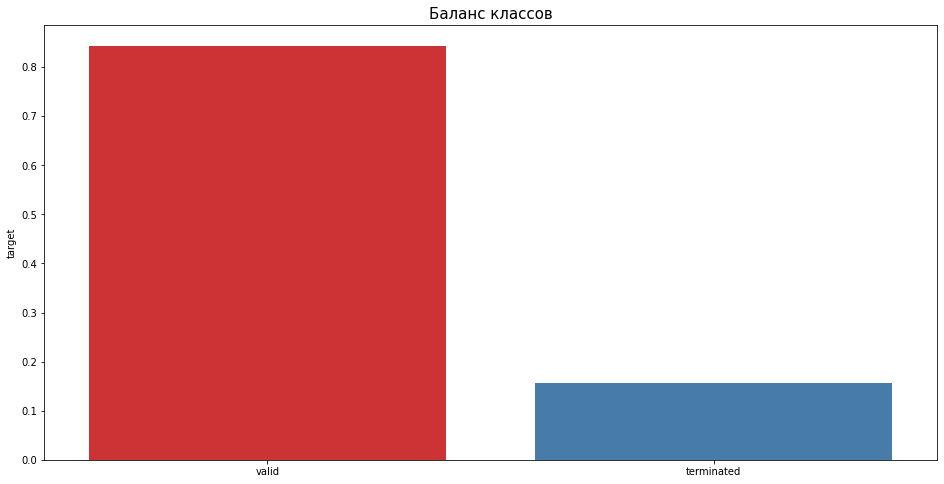

In [47]:
plt.figure(figsize=(16,8))
sns.barplot(x=[0,1], 
            y=sum_df['target'].value_counts() / sum_df.shape[0], palette = "Set1")
plt.xticks([0,1], ['valid', 'terminated'])
plt.title('Баланс классов', fontsize=15);

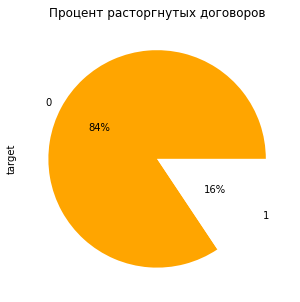

In [48]:
colors = ( "orange", "white") 
sum_df['target'].value_counts().plot(
    kind = 'pie', 
    y = id,
    autopct = '%1.0f%%',
    colors = colors,
    figsize=(5,5), 
    title = 'Процент расторгнутых договоров');

Яркий дисбаланс (получился packman)) классов. Расторгнутых договоров 16%, посмотрим, какими признаками обладают клиенты, расторгнувшие договор.

В зависимости от целевого признака построим графики сравнения

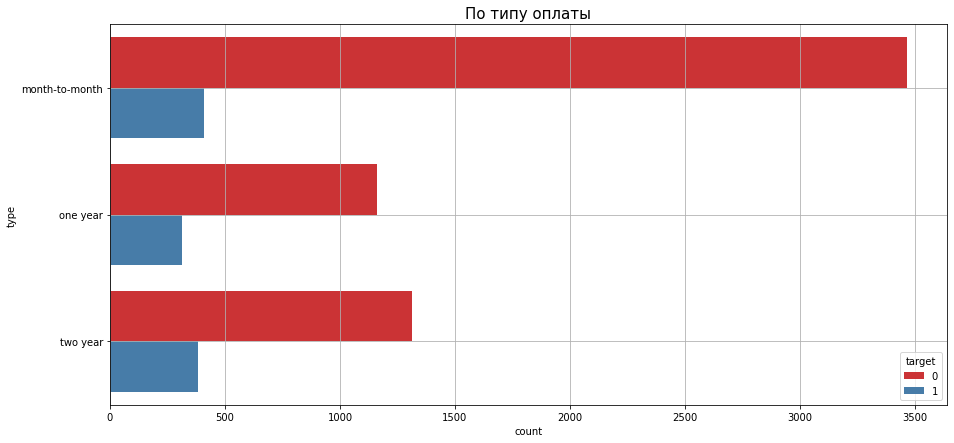

In [49]:
plt.figure(figsize=(15, 7))
sns.countplot(data=sum_df, y="type", hue="target", palette="Set1")
plt.title("По типу оплаты", fontsize=15)
plt.grid();

Таргеты более-менее равно мерны по 3 типам, расторгались все типы оплаты, помесячные несколько чаще

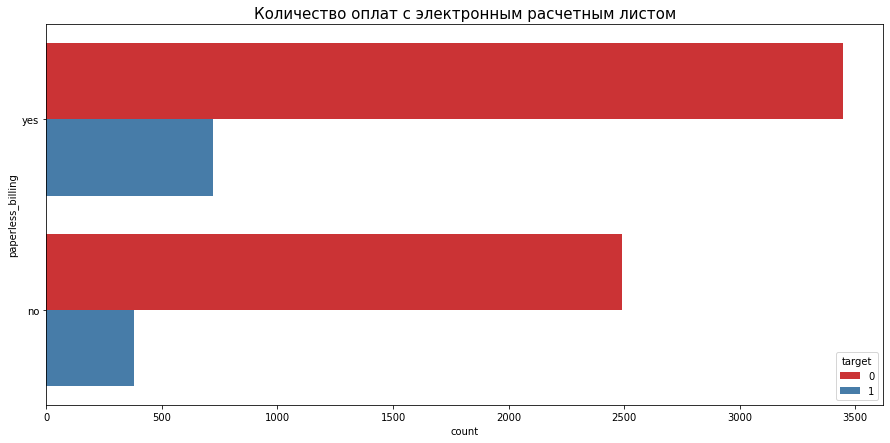

In [50]:
plt.figure(figsize=(15, 7))
sns.countplot(data=sum_df, y="paperless_billing", hue="target", palette="Set1")
plt.title("Количество оплат с электронным расчетным листом", fontsize=15);

Часто имеено электронным расчетным листом пользовались ушедшие клиенты

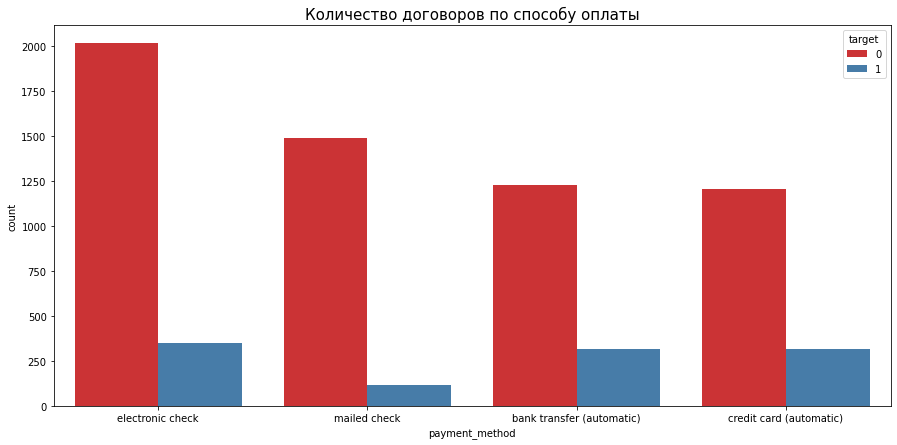

In [51]:
plt.figure(figsize=(15, 7))
sns.countplot(data=sum_df, x="payment_method", hue="target", palette="Set1")
plt.title("Количество договоров по способу оплаты", fontsize=15);

Чуть меньше расторгались клиенты - mail check

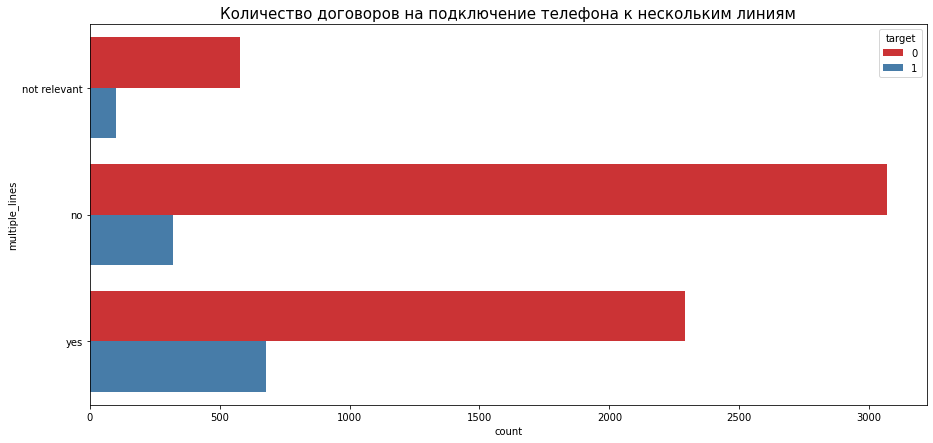

In [52]:
plt.figure(figsize=(15, 7))
sns.countplot(data=sum_df, y="multiple_lines", hue="target", palette="Set1")
plt.title("Количество договоров на подключение телефона к нескольким линиям", fontsize=15);

Телефоны таргетов чаще подключали, чем не подключали, к нескольким линиям

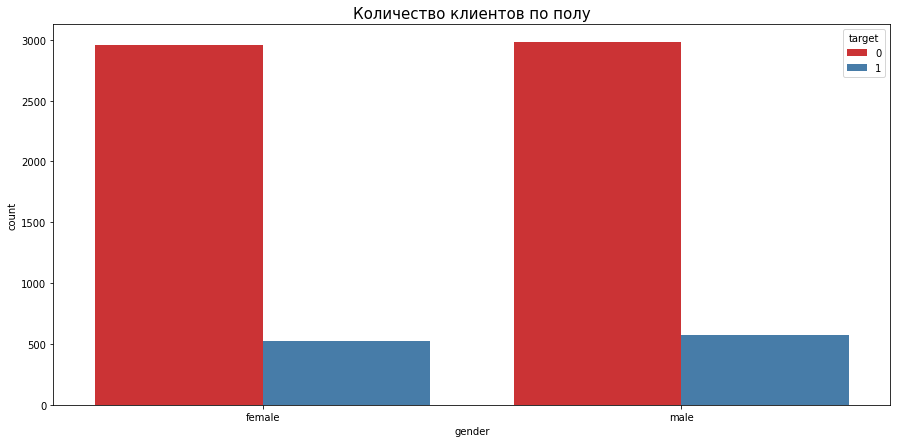

In [53]:
plt.figure(figsize=(15, 7))
sns.countplot(data=sum_df, x="gender", hue="target", palette="Set1")
plt.title("Количество клиентов по полу", fontsize=15);

Равномерно

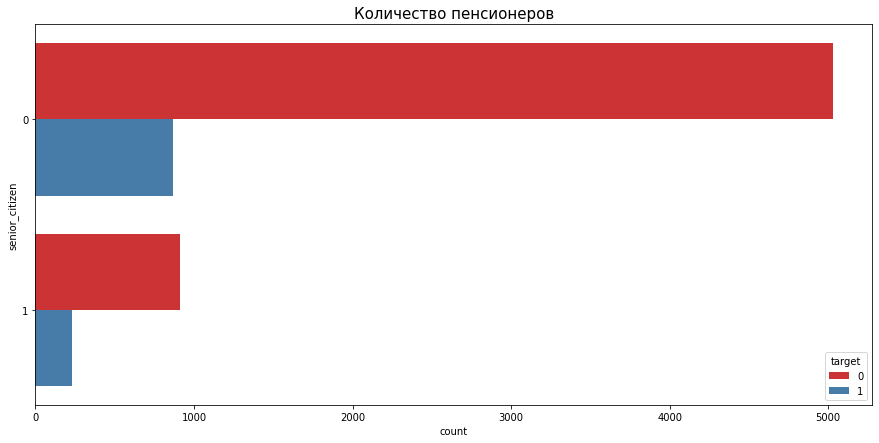

In [54]:
plt.figure(figsize=(15, 7))
sns.countplot(data=sum_df, y="senior_citizen", hue="target", palette = "Set1")
plt.title("Количество пенсионеров", fontsize=15);

Больше непенсионеров, но это и так ожидаемо.

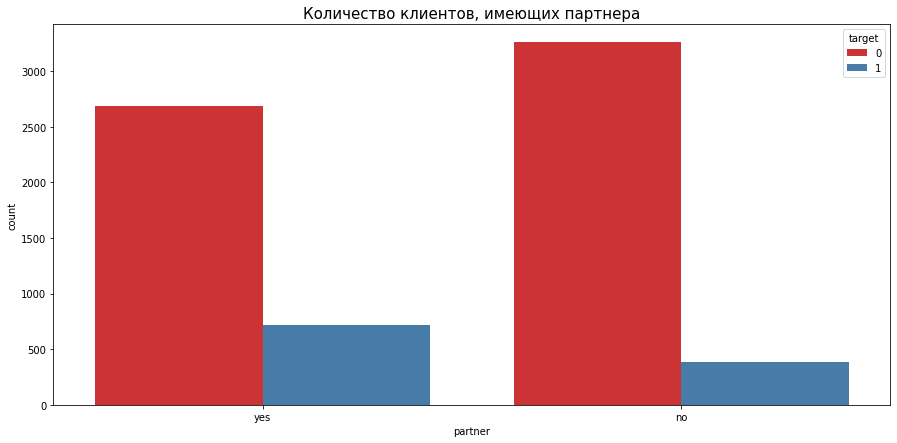

In [55]:
plt.figure(figsize=(15, 7))
sns.countplot(data=sum_df, x="partner", hue="target", palette="Set1")
plt.title("Количество клиентов, имеющих партнера", fontsize=15);

И с партнерами и без партнеров договоры расторгались, с парнером чаще

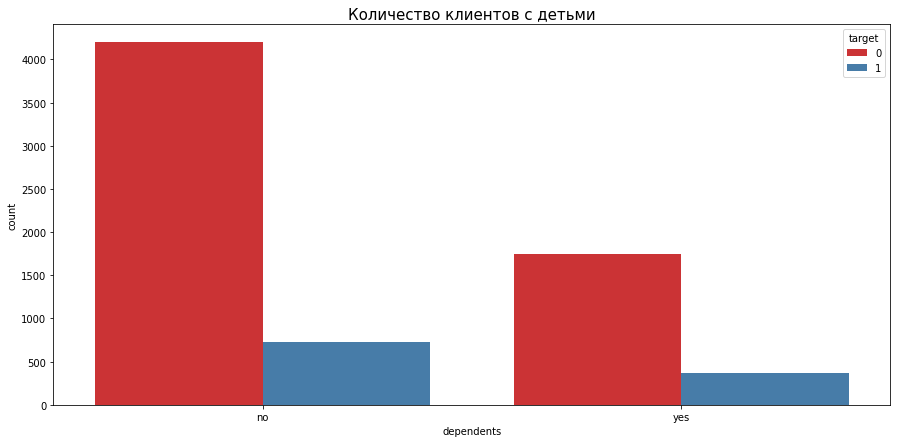

In [56]:
plt.figure(figsize=(15, 7))
sns.countplot(data=sum_df, x="dependents", hue="target", palette="Set1")
plt.title("Количество клиентов с детьми", fontsize=15);

Клиенты как с детьми, так и без детей расторгали договоры

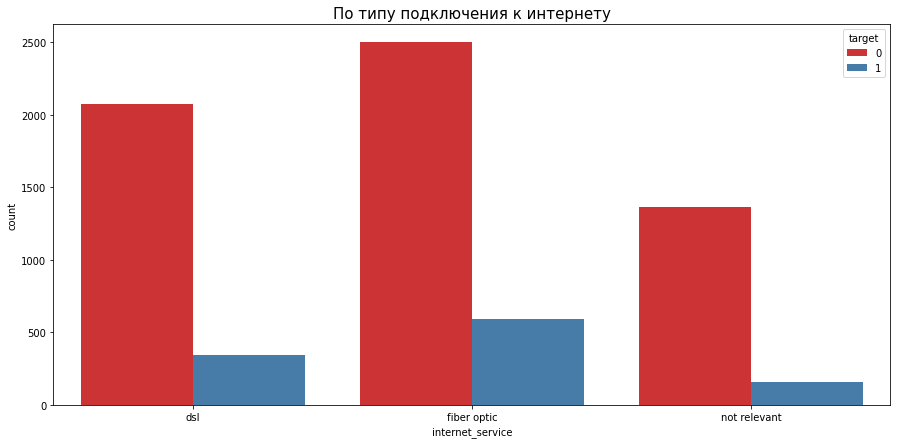

In [57]:
plt.figure(figsize=(15, 7))
sns.countplot(data=sum_df, x="internet_service", hue="target", palette="Set1")
plt.title("По типу подключения к интернету", fontsize=15);

Чаще всего fiber optic, но не на столько, чтобы заметить сильную корреляцию.

Рассмотрим распределение количественных признаков, создадим новый признак - длительность контракта в днях "contract_duration"

In [58]:
sum_df["contract_duration"] = (sum_df["end_date"] - sum_df["begin_date"]).dt.days

In [59]:
num_features = ["monthly_charges",
                "total_charges",
                "contract_duration"]

cat_features = ["type",
                "paperless_billing",
                "payment_method",
                "gender",
                "senior_citizen",
                "partner",
                "dependents",
                "internet_service",
                "online_security",
                "online_backup",
                "device_protection",
                "tech_support",
                "streaming_tv",
                "streaming_movies",
                "multiple_lines",
                "target"]

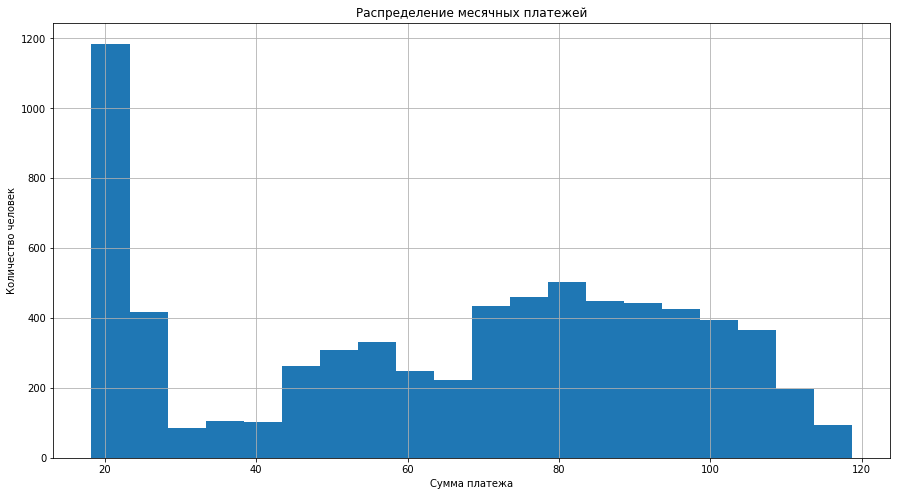

In [60]:
sum_df['monthly_charges'].hist(figsize=(15,8), bins=20)
plt.title("Распределение месячных платежей")
plt.xlabel("Сумма платежа")
plt.ylabel("Количество человек");

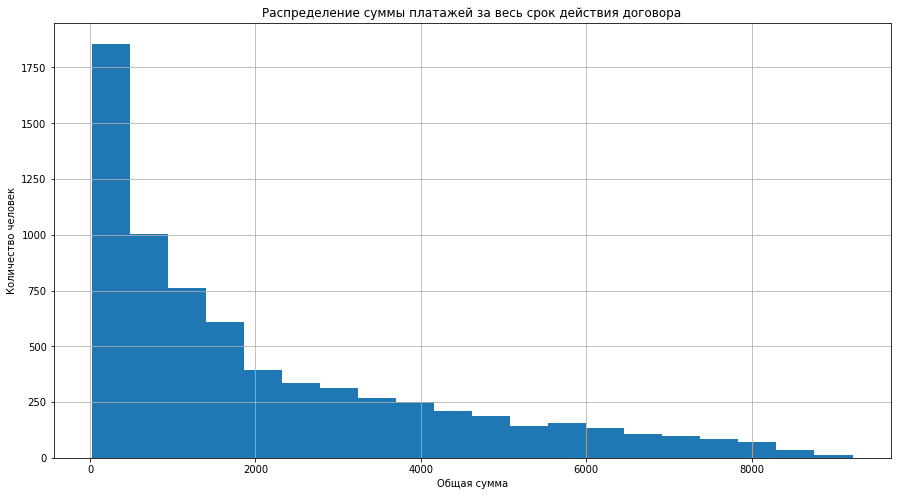

In [61]:
sum_df['total_charges'].hist(figsize=(15,8), bins=20)
plt.title("Распределение суммы платажей за весь срок действия договора")
plt.xlabel("Общая сумма")
plt.ylabel("Количество человек");

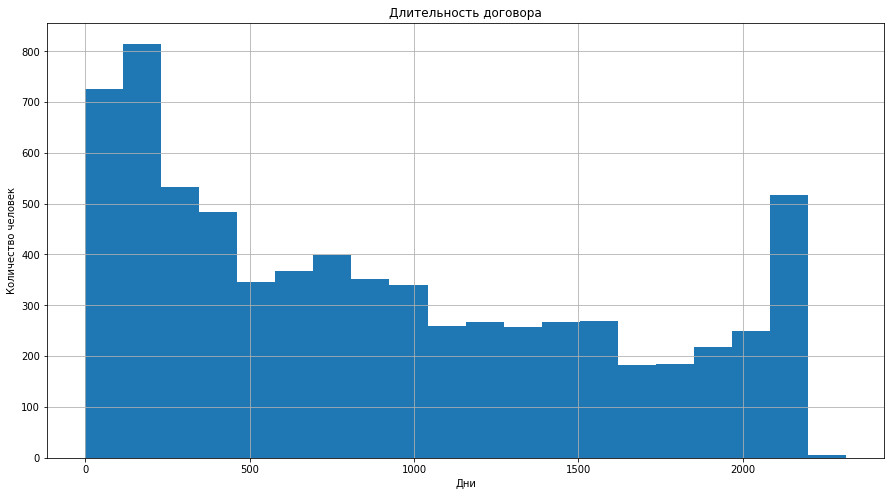

In [62]:
sum_df['contract_duration'].hist(figsize=(15,8), bins=20)
plt.title("Длительность договора")
plt.xlabel("Дни")
plt.ylabel("Количество человек");

In [63]:
sum_df[num_features].describe()

,monthly_charges,total_charges,contract_duration
count,7039.000000,7039.000000,7039.000000
mean,64.773000,2115.147585,898.435005
std,30.079738,2111.731243,682.820576
min,18.250000,19.050000,0.000000
25%,35.550000,437.500000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


In [64]:
sum_df[num_features].describe()

,monthly_charges,total_charges,contract_duration
count,7039.000000,7039.000000,7039.000000
mean,64.773000,2115.147585,898.435005
std,30.079738,2111.731243,682.820576
min,18.250000,19.050000,0.000000
25%,35.550000,437.500000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


Построим распределение количественных признаков относительно значений целевого признака

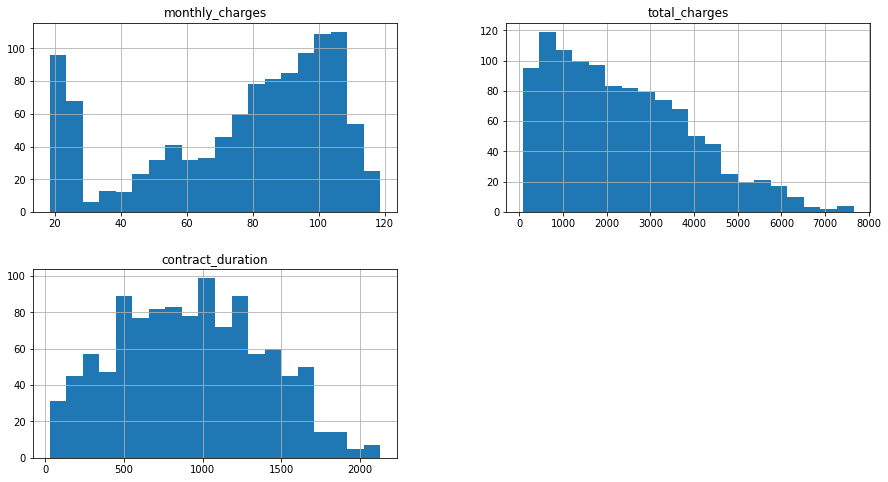

In [65]:
sum_df[sum_df["target"] == 1][num_features].hist(figsize=(15,8), bins=20);

При сравнении распределений среди всех контрактов и среди расторгнутых можно заметить, что много бывших клиентов имели высокую ежемесячную плату за услуги (пик 100 и выше, которого нет на общем распределении).
Распределение сроков действия договоров клиентов, покинувших компанию, близко к нормальному.

Построим матрицу корреляции 

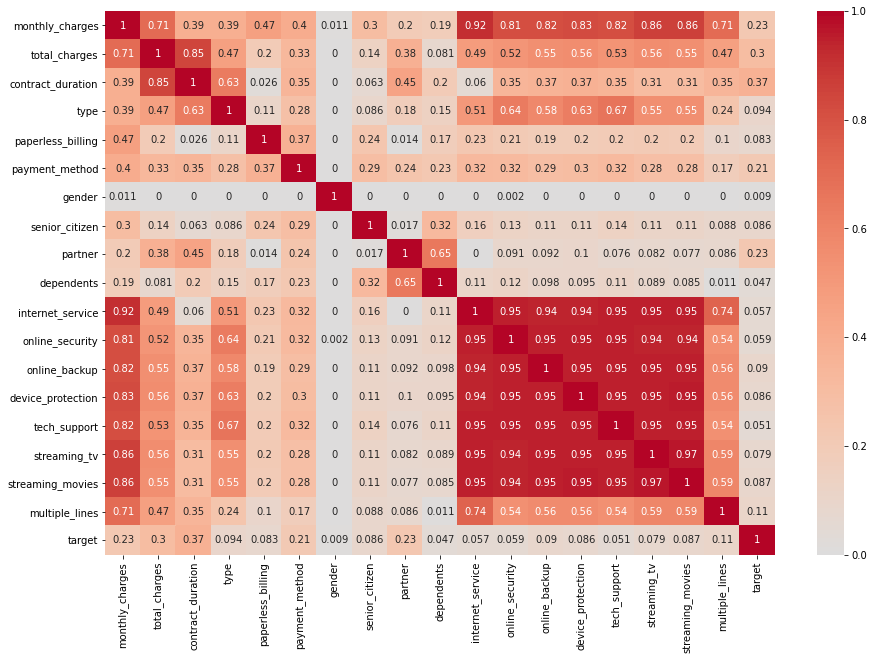

In [66]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(sum_df[num_features+cat_features].phik_matrix(interval_cols=['monthly_charges',
                                                                       'total_charges',
                                                                        'contract_duration']),
            cmap='coolwarm', center=0, annot=True);

Целевой признак коррелирует с длительностью контракта больше всего, а также с общей суммой затрат на пользование услугами/месячной суммой затрат и методом оплаты, и с самими услугами: streaming_tv, multiple_lines, streaming_movies и device_protection, online_backup. 
Построим тепловую карту несильно коррелирующих между собой признаков для чистоты обучения модели, устраним мультиколлинеарность.

In [67]:
num_features = ["monthly_charges",
                "contract_duration"]

cat_features = ["type",
                "paperless_billing",
                "payment_method",
                "gender",
                "senior_citizen",
                "partner",
                "dependents",
                "multiple_lines"]

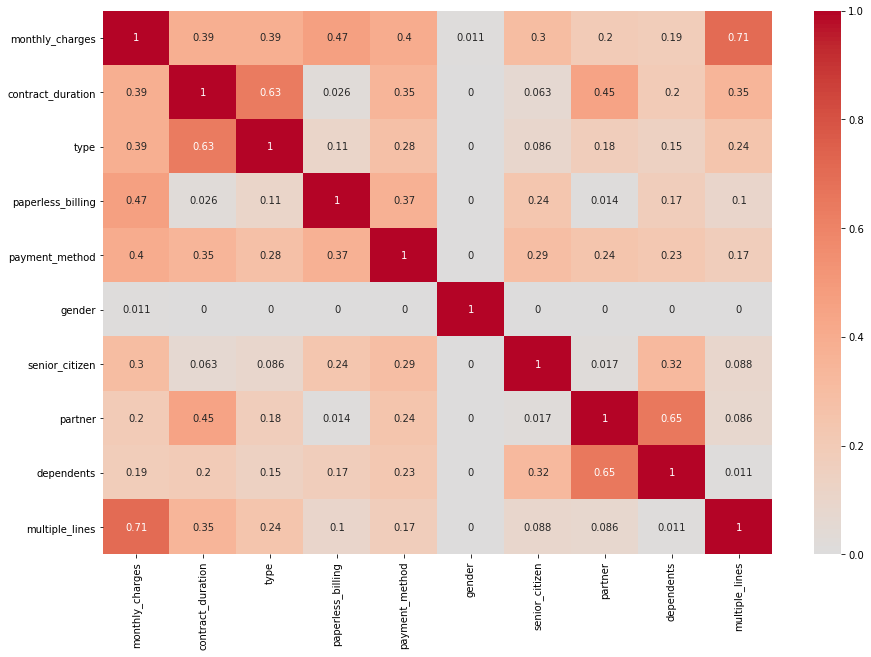

In [68]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(sum_df[num_features+cat_features].phik_matrix(interval_cols=["monthly_charges",
                                                                       "contract_duration"]),
                                            annot=True, center=0, cmap= 'coolwarm');

Создадим новый признак, который будет представлять собой сумму всех подключенных услуг у клиентов.

In [69]:
sum_df["sum"] = (sum_df['online_security'] == "yes").astype('int')+(
    sum_df['online_backup'] == "yes").astype('int')+(sum_df['online_backup'] == "yes").astype('int')+(
    sum_df['device_protection'] == "yes").astype('int')+(sum_df['tech_support'] == "yes").astype('int')+(
    sum_df['streaming_tv'] == "yes").astype('int')+(sum_df['streaming_movies'] == "yes").astype('int')+(
    sum_df['multiple_lines'] == "yes").astype('int')

In [70]:
sum_df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,phone,gender,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,target,contract_duration,sum
0,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,not relevant,not relevant,female,...,no,yes,no,no,no,no,yes,0,31,2
1,2017-04-01,2020-02-01,one year,no,mailed check,56.95,2071.84,no,yes,male,...,yes,no,yes,no,no,no,yes,0,1036,2
2,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,no,yes,male,...,yes,yes,no,no,no,no,yes,0,123,3
3,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1960.60,not relevant,not relevant,male,...,yes,no,yes,yes,no,no,yes,0,1371,3
4,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,no,yes,female,...,no,no,no,no,no,no,yes,0,153,0


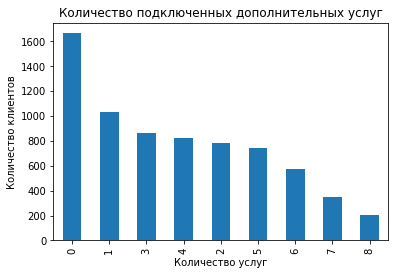

In [71]:
sum_df["sum"].value_counts().plot(kind="bar",
                                  xlabel="Количество услуг", 
                                  ylabel="Количество клиентов", 
                                  title="Количество подключенных дополнительных услуг");

Сделаем категории клиентов в зависимости от суммы подключенных им услуг.

In [72]:
def sum_category(sum_df):
    if sum_df == 0:
        return "Not any"
    if sum_df == 1:
        return "One"
    if 2 <= sum_df <= 6:
        return "Some"
    if sum_df >= 7:
        return "Many"

In [73]:
sum_df["categories"] = sum_df["sum"].apply(sum_category)

In [74]:
num_features = ["contract_duration"]

cat_features = ["type",
                "paperless_billing",
                "payment_method",
                "gender",
                "senior_citizen",
                "partner",
                "dependents",
                "multiple_lines",
                "categories"]

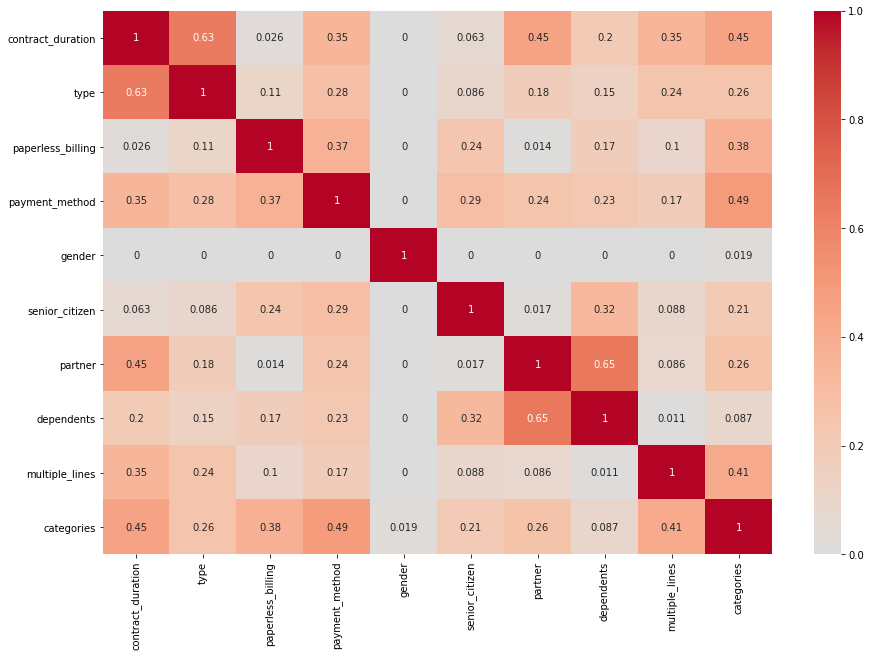

In [75]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(sum_df[num_features+cat_features].phik_matrix(interval_cols=["monthly_charges",
                                                                       "contract_duration"]
                                                       ),
                                            annot=True, center=0, cmap= "coolwarm");

## Обучение моделей

Подготовим данные к обучению,обучим модели и проверим качество наилучшей модели на тестовой выборке. 
Нам даны условия:

- Целевая метрика - AUC-ROC, значение целевой метрики лучшей модели должно быть больше или равно 0.85.
- RANDOM STATE - 160924.
- Соотношение обучающей и тестовой выборок – 3:1.
- Оценку качества модели необходимо проводить на кросс-валидации.
- При обучении следует использовать не менее двух разных алгоритмов.

Качество лучшей модели необходимо проверить для тестовой выборке. Помимо основной метрики, на тестовой выборке также следует посчитать и интерпретировать значение Accuracy.

In [76]:
target = sum_df["target"]
features = sum_df[num_features+cat_features]

In [77]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

Закодируем признаки

In [78]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=1000)
oe_features_train = features_train.copy()
oe_features_test = features_test.copy()
oe_features_train[cat_features] = encoder.fit_transform(features_train[cat_features])
oe_features_test[cat_features] = encoder.transform(features_test[cat_features])
oe_features_train.head()

,contract_duration,type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines,categories
932,2191,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3320,396,0.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0,3.0
6961,790,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,3.0
3591,276,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0
3255,671,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,3.0


Масштабируем количественный признак.

In [79]:
def scale_data(data_train, data_test):
    scaler = StandardScaler()
    data_train[num_features] = scaler.fit_transform(data_train[num_features])
    data_test[num_features] = scaler.transform(data_test[num_features])
    return data_train, data_test

In [80]:
oe_features_train, oe_features_test = scale_data(oe_features_train, oe_features_test)
features_train, features_test = scale_data(features_train, features_test)

Поменяем тип данных на category

In [81]:
features_train[cat_features] = features_train[cat_features]. astype('category')
features_test[cat_features] = features_test[cat_features]. astype('category')

Для анализа результатов работы моделей создадим пустые списки, в которые будем добавлять необходимые значения по ходу обучения моделей.

In [82]:
best_model = []
best_params = []
best_roc_auc = []

In [83]:
def cv_estimator(model, params, features_train, target_train):
    model = model
    params = params
    grid = GridSearchCV(model, params, scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(features_train, target_train)
    best_model.append(grid.best_estimator_)
    best_params.append(grid.best_params_)
    best_roc_auc.append(grid.best_score_)
    print(f'Гиперпараметры лучшей модели: {grid.best_params_}')
    print(f'AUC-ROC лучшей модели: {grid.best_score_}')
    return grid  

Обчение DesicionTreeClassifier

In [84]:
grid_dt = cv_estimator(DecisionTreeClassifier(random_state=RANDOM_STATE, 
                                              class_weight='balanced'),
                      {'max_depth': range(1, 6), 'min_samples_leaf': range(1, 6)},
                      oe_features_train, target_train)

Гиперпараметры лучшей модели: {'max_depth': 5, 'min_samples_leaf': 4}
AUC-ROC лучшей модели: 0.7878723388813131


Обучение RandomForestClassifier

In [85]:
grid_rf = cv_estimator(RandomForestClassifier(random_state=RANDOM_STATE,
                                             class_weight='balanced'),
                      {'max_depth': [None] + [i for i in range(1, 7)],
                       'min_samples_leaf': range(1, 6),
                       'n_estimators': [100, 200, 300]},
                       oe_features_train, target_train)

Гиперпараметры лучшей модели: {'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 100}
AUC-ROC лучшей модели: 0.8256397487060321


Обучение CatBoostClassifier

In [86]:
grid_cb = cv_estimator(CatBoostClassifier(random_state=RANDOM_STATE, verbose=False,
                                         auto_class_weights='Balanced'),
                      {'depth':  range(1, 7),
                       'learning_rate':[.1, .3, .5],
                       'iterations': [100, 200, 300]},
                        oe_features_train, target_train)

Гиперпараметры лучшей модели: {'depth': 2, 'iterations': 300, 'learning_rate': 0.5}
AUC-ROC лучшей модели: 0.9335130421132994


Обучение LGBMClassifier

In [87]:
grid_gbm = cv_estimator(LGBMClassifier(random_state=RANDOM_STATE,
                                      class_weight='balanced'),
                      {'max_depth': [None] + [i for i in range(1, 7)],
                       'learning_rate':[.1, .3, .5],
                       'n_estimators': [100, 200, 300]},
                       features_train, target_train)

Гиперпараметры лучшей модели: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 300}
AUC-ROC лучшей модели: 0.9127927793734733


Обобщение результатов обучения моделей

In [88]:
models_compared = (pd.DataFrame
                   (
    {
        'модель':['DecisionTreeClassifier',
                  'RandomForestClassifier',
                  'CatBoostClassifier',
                  'LGBMClassifier'],
        'гиперпараметры лучшей модели': best_params,
        'AUC_ROC': best_roc_auc
    }
                   )
                   .set_index(['модель'])
                   .style
                   .background_gradient(cmap='Blues', axis=0)
                   .set_caption("Лучшие результаты AUC-ROC на кросс-валидации")
                   .set_properties(subset=['AUC_ROC'], **{'width': '300px'})
                   .set_table_styles(
                       [
                           {
                               'selector': 'caption',
                               'props': 
                               [('color', 'black'),
                                ('font-size', '18px')]
                           }
                       ]
                   )
                  )

models_compared

,гиперпараметры лучшей модели,AUC_ROC
модель,,
DecisionTreeClassifier,"{'max_depth': 5, 'min_samples_leaf': 4}",0.787872
RandomForestClassifier,"{'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 100}",0.825640
CatBoostClassifier,"{'depth': 2, 'iterations': 300, 'learning_rate': 0.5}",0.933513
LGBMClassifier,"{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 300}",0.912793


Лучший результат на кросс-валидации показала модель LGBMClassifier c гиперпараметрами {'depth': 2, 'iterations': 300, 'learning_rate': 0.5}

Сохраняем лучший результат

In [89]:
best_result = 0
for i in range(len(best_roc_auc)):
    if best_roc_auc[i] > best_result:
        best_result = best_roc_auc[i]
        model_best = best_model[i]

## Тестирование лучшей модели

### Метрика ROC-AUC

Определим значение ROC-AUC для лучшей модели на тестовой выборке. 

In [90]:
probabilities_test = model_best.predict_proba(oe_features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_test = roc_auc_score(target_test, probabilities_one_test)
print("Значение ROC_AUC наилучшей модели на тестовой выборке:", roc_auc_test)

Значение ROC_AUC наилучшей модели на тестовой выборке: 0.9495757575757575


Визуализируем показатель AUC-ROC на графике, изображающем ROC-кривую, в сопоставлении с данными случайной модели. На графике видно, что значение AUC_ROC выбранной наилучшей модели существенно отличается от значения для случайной модели (последнее всегда равно 0.5)

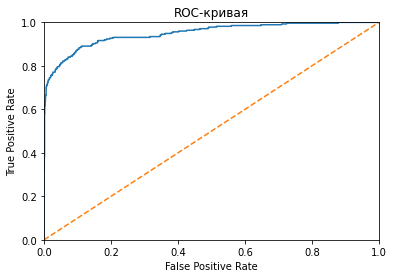

In [91]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.show()

### Метрика Accuracy

In [92]:
predictions_test = model_best.predict(oe_features_test)
accuracy_test = accuracy_score(target_test, predictions_test)
print("Значение accuracy наилучшей модели на тестовой выборке:", accuracy_test)

Значение accuracy наилучшей модели на тестовой выборке: 0.9


Предсказания нашей лучшей модели верны в 90% случаев, соответственно, ошибки составляют 10% предсказаний.

Рассмотрим, какие признаки больше всего влияют на принятие решения моделью об отнесении к тому или иному классу.

In [93]:
model_best.feature_importances_

array([8.91570524e+01, 2.93899207e+00, 2.55803337e-01, 1.74158002e+00,
       8.29351393e-02, 1.96079348e-01, 1.34100276e+00, 1.75900446e-01,
       1.71309124e+00, 2.39756322e+00])

In [94]:
pd.DataFrame(model_best.feature_importances_, index = num_features+cat_features,
             columns=["feature_importances"]).sort_values(by="feature_importances",
                                                          ascending=False)

,feature_importances
contract_duration,89.157052
type,2.938992
categories,2.397563
payment_method,1.741580
multiple_lines,1.713091
partner,1.341003
paperless_billing,0.255803
senior_citizen,0.196079
dependents,0.175900
gender,0.082935


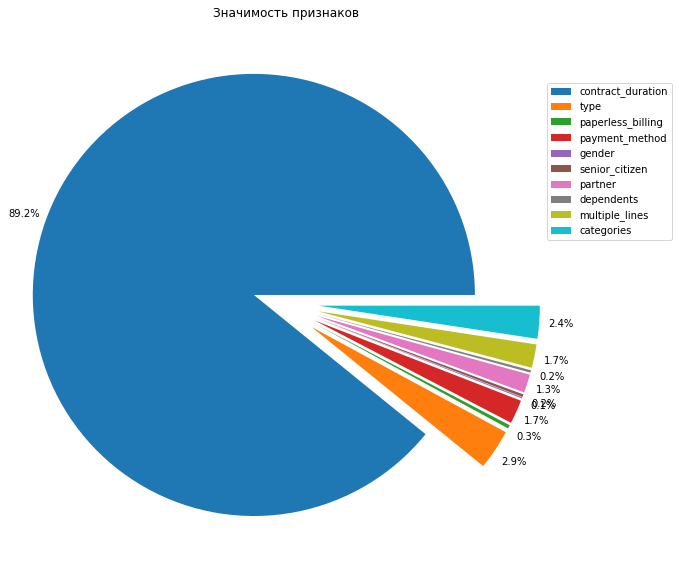

In [95]:
explode = [0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(model_best.feature_importances_, explode=explode, autopct='%1.1f%%', pctdistance=1.1)
ax.axis("equal")
plt.legend(num_features+cat_features, loc=1, bbox_to_anchor=(1.2,0.9))
plt.title("Значимость признаков")
plt.show()

### Матрица ошибок

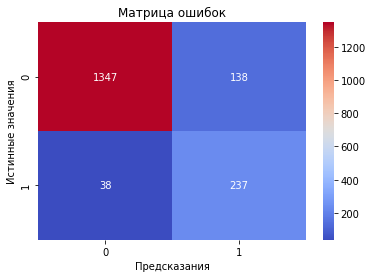

In [96]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(target_test, predictions_test),
            cmap='coolwarm', fmt='d', annot=True)
plt.title('Матрица ошибок')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.show()

In [97]:
print(f'Всего {target_test.shape[0]}')
target_test.value_counts()

Всего 1760


0    1485
1     275
Name: target, dtype: int64

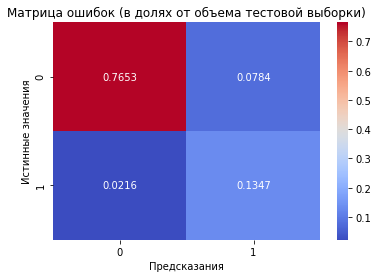

In [98]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(target_test, predictions_test) / 
            confusion_matrix(target_test, predictions_test).sum(),
            cmap='coolwarm', fmt=".4f", annot=True)
plt.title('Матрица ошибок (в долях от объема тестовой выборки)')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.show()

Количество значений обоих классов целевого признака, которые лучшая модель предсказала правильно или неправильно на тестовой выборке, представлены на матрице. Всего тестовая выборка содержит данные о 1760 клиентах, 275 из которых расторгли договор с ТелеДом. По главной диагонали матрицы расположены правильные ответы, в сумме составляющие 90% от всей выборки (accuracy). При этом модель правильно предсказала уход 237 клиентов и не предсказала уход 38 клиентов. В 138 случаях модель предсказала уход клиентов, которые на самом деле остались. При прогнозировании ухода клиентов из компании такие ложноположительные результаты приведут к тому, что промокоды и специальные условия будут предложены клиентам, которые и так остались бы в компании.

## Итог

1. Необходимо использовать модель CatBoostClassifier для предсказания расторжения договора клиентом. 
2. Именно длительность конракта является индикатором для работы модели в отношении тех, кто не уйдет или класса 0 (я смотрела по средством библиотеки shap).
3. Портрет ушедшего клиента: 
- помесячно оплачивает чаще всего с электронным расчетным листом, телефон подключен к нескольким линиям. Важно понимать, что отток клиентов с услугой MultipleLines произошел в том числе из-за появления IP-телефонии взамен стационарной телефонной связи, которую предлагает ТелеДом. Облачные телефоны обладают широким набором возможностей. Пользователи могут совершать и принимать телефонные вызовы на телефонах, компьютерах и мобильных устройствах, используя во всех случаях один и тот же номер телефона, важные вызовы никогда не будут пропущены. 
- Среди ушедших из компании клиентов больше доля состоящих в браке и имеющих иждивенцев. 
- Клиенты, ушедшие из компании, чаще пользовались дополнительными услугами и их месячные платежи были высоки. 

Для прекращения оттока небходимо продумать какой-то механизм предоставления скидок или бонусы за количество услуг, оформленных допом.